<a href="https://colab.research.google.com/github/Aouisssaoui-Zied/fullpack-ia-module-2/blob/main/TEST_TECHNIQUE_EN_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TASK 1 — XGBoost pour prédire les défauts de paiement

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data= pd.read_excel('/content/drive/MyDrive/Full pack IA/Module2:Machine Learning/default of credit card clients.xls', skiprows=1)

In [6]:
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


1. Feature Engineering (âge, montant, historique)

In [7]:
# Suppression de la colonne ID (inutile pour la prédiction)
data.drop(columns=["ID"], inplace=True)

# Regrouper les valeurs rares ou inconnues pour EDUCATION et MARRIAGE
data["EDUCATION"] = data["EDUCATION"].replace({0: 4, 5: 4, 6: 4})  # 4 = autre
data["MARRIAGE"] = data["MARRIAGE"].replace({0: 3})  # 3 = autre

# Création de nouvelles features basées sur le montant et l’historique
data["TOTAL_BILL"] = data[[f"BILL_AMT{i}" for i in range(1, 7)]].sum(axis=1)      # montant total dû
data["TOTAL_PAY"] = data[[f"PAY_AMT{i}" for i in range(1, 7)]].sum(axis=1)        # montant total remboursé
data["PAY_MEAN"] = data[[f"PAY_{i}" for i in [0, 2, 3, 4, 5, 6]]].mean(axis=1)    # moyenne des retards de paiement

 2. Gérer les valeurs manquantes

In [8]:
data.isnull().sum()

,0
LIMIT_BAL,0
SEX,0
EDUCATION,0
MARRIAGE,0
AGE,0
PAY_0,0
PAY_2,0
PAY_3,0
PAY_4,0
PAY_5,0


Il n’y a pas de valeurs manquantes

3. Optimiser les hyperparamètres (max_depth, learning_rate, n_estimators)

In [9]:
# Séparation des features et de la cible
X = data.drop("default payment next month", axis=1)
y = data["default payment next month"]
# (X) et cible (y)
X = data.drop(columns=["default payment next month"])  # La cible est "default payment next month"
y = data["default payment next month"]

In [10]:
# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
from sklearn.model_selection import GridSearchCV
# Modèle avec GridSearchCV pour optimiser les hyperparamètres
model = XGBClassifier(eval_metric='logloss')

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200]
}

grid = GridSearchCV(model, param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=1)

In [45]:
# 10. Meilleurs hyperparamètres
print("Best parameters:", grid.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


 4. Importance des variables

In [13]:
best_model = grid.best_estimator_
importances = best_model.feature_importances_

features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

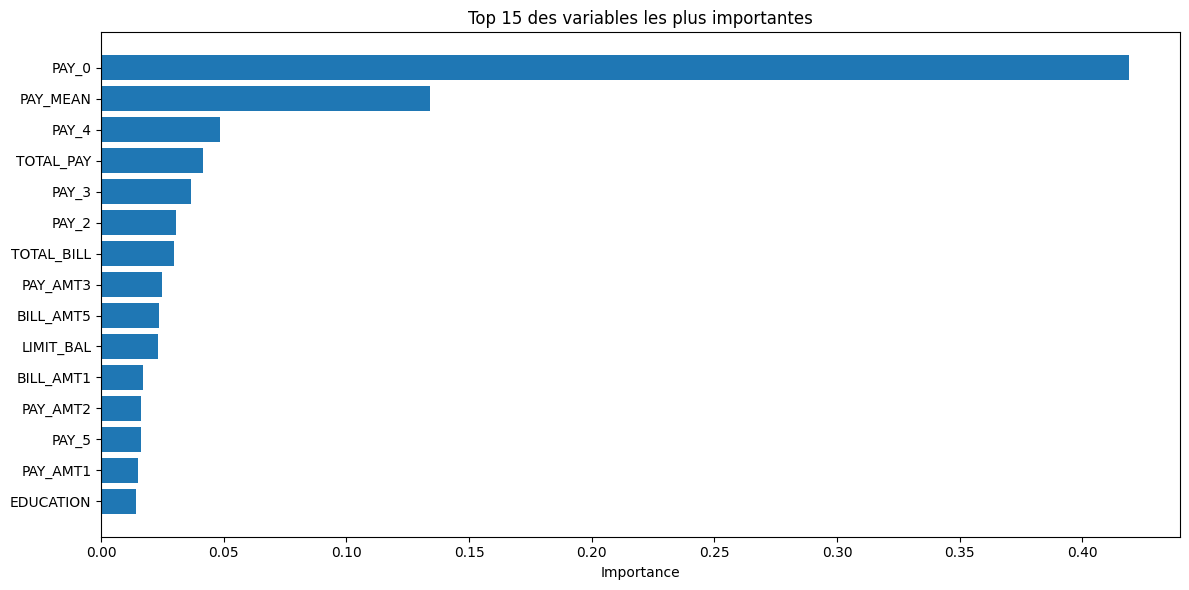

In [14]:
# Affichage
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1])
plt.title("Top 15 des variables les plus importantes")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

 5. Évaluation (AUC, F1 Score)

In [15]:
from sklearn.metrics import roc_auc_score, f1_score

# Prédiction
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# AUC et F1
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f"AUC : {auc:.4f}")
print(f"F1 Score : {f1:.4f}")


AUC : 0.7808
F1 Score : 0.4650


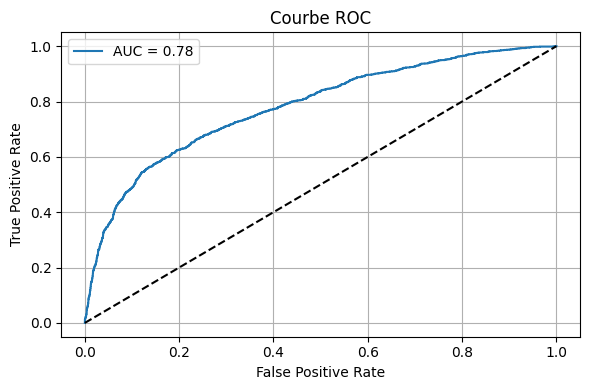

In [16]:
from sklearn.metrics import roc_curve

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Courbe ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


**TASK 2 — SVM pour la classification de chiffres manuscrits **

 1. Importation des bibliothèques et chargement du dataset

In [17]:
# Importations nécessaires
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Chargement des données
digits = load_digits()
X, y = digits.data, digits.target


In [18]:
# 2. Diviser les données en ensemble d'entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 2. Réduction de dimension avec PCA

In [19]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


3. Comparer les différents kernels : linéaire, RBF, poly

3.1. kernel linéaire

In [20]:
# Kernel linéaire
clf_linear = SVC(kernel='linear')
clf_linear.fit(X_train_pca, y_train)
y_pred_linear = clf_linear.predict(X_test_pca)
print("=== Kernel: Linear ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_linear):.4f}")
print(classification_report(y_test, y_pred_linear))

=== Kernel: Linear ===
Accuracy: 0.5306
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        33
           1       0.28      0.75      0.41        28
           2       0.62      0.70      0.66        33
           3       0.35      0.44      0.39        34
           4       0.95      0.89      0.92        46
           5       0.40      0.09      0.14        47
           6       0.82      0.91      0.86        35
           7       0.67      0.76      0.71        34
           8       0.18      0.23      0.21        30
           9       0.00      0.00      0.00        40

    accuracy                           0.53       360
   macro avg       0.49      0.54      0.50       360
weighted avg       0.50      0.53      0.49       360



3.2. Kernel RBF

In [21]:
# Kernel RBF
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(X_train_pca, y_train)
y_pred_rbf = clf_rbf.predict(X_test_pca)
print("\n=== Kernel: RBF ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf):.4f}")
print(classification_report(y_test, y_pred_rbf))


=== Kernel: RBF ===
Accuracy: 0.5389
              precision    recall  f1-score   support

           0       0.62      0.70      0.66        33
           1       0.31      0.43      0.36        28
           2       0.66      0.58      0.61        33
           3       0.36      0.47      0.41        34
           4       0.98      0.89      0.93        46
           5       0.43      0.06      0.11        47
           6       0.84      0.91      0.88        35
           7       0.68      0.74      0.70        34
           8       0.18      0.30      0.23        30
           9       0.37      0.35      0.36        40

    accuracy                           0.54       360
   macro avg       0.54      0.54      0.52       360
weighted avg       0.56      0.54      0.53       360



3.3.kernel Polynomial

In [22]:
# Kernel Polynomial
clf_poly = SVC(kernel='poly')
clf_poly.fit(X_train_pca, y_train)
y_pred_poly = clf_poly.predict(X_test_pca)
print("\n=== Kernel: Polynomial ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_poly):.4f}")
print(classification_report(y_test, y_pred_poly))


=== Kernel: Polynomial ===
Accuracy: 0.5000
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        33
           1       0.22      0.96      0.36        28
           2       0.81      0.52      0.63        33
           3       0.34      0.32      0.33        34
           4       0.93      0.87      0.90        46
           5       0.29      0.09      0.13        47
           6       0.91      0.89      0.90        35
           7       0.75      0.62      0.68        34
           8       0.14      0.13      0.14        30
           9       0.00      0.00      0.00        40

    accuracy                           0.50       360
   macro avg       0.52      0.52      0.48       360
weighted avg       0.52      0.50      0.48       360



3.4. Comparison

Kernel linéaire : L'accuracy est de 0.5306 et le F1-score est plutôt équilibré entre les classes, avec une bonne performance pour certaines classes comme le chiffre 4, mais un faible score pour des chiffres comme le 9.

Kernel RBF : L'accuracy augmente légèrement à 0.5389 par rapport au linéaire, et le F1-score montre de meilleures performances pour certaines classes (comme le 6 et le 4), mais reste relativement faible pour d'autres, en particulier le chiffre 5.

Kernel Polynomial : L'accuracy est la plus basse à 0.5000, avec un F1-score également moins performant. Les chiffres comme le 1 et le 4 ont de bons scores, mais d'autres chiffres comme le 9 et le 5 ont des performances médiocres.

En résumé, le kernel RBF offre la meilleure précision et performance globale, mais les trois noyaux montrent des faiblesses sur certaines classes, comme le chiffre 5 et le chiffre 9.

4. Tester la scalabilité (temps d'entraînement)

In [23]:
import time

# Kernel linéaire
start_time = time.time()
clf_linear.fit(X_train_pca, y_train)
end_time = time.time()
print(f"Temps d'entraînement pour le noyau linéaire : {end_time - start_time:.4f} secondes")

# Kernel RBF
start_time = time.time()
clf_rbf.fit(X_train_pca, y_train)
end_time = time.time()
print(f"Temps d'entraînement pour le noyau RBF : {end_time - start_time:.4f} secondes")

# Kernel Polynomial
start_time = time.time()
clf_poly.fit(X_train_pca, y_train)
end_time = time.time()
print(f"Temps d'entraînement pour le noyau Polynomial : {end_time - start_time:.4f} secondes")


Temps d'entraînement pour le noyau linéaire : 0.0573 secondes
Temps d'entraînement pour le noyau RBF : 0.0449 secondes
Temps d'entraînement pour le noyau Polynomial : 0.0473 secondes


5. Visualiser les marges et erreurs

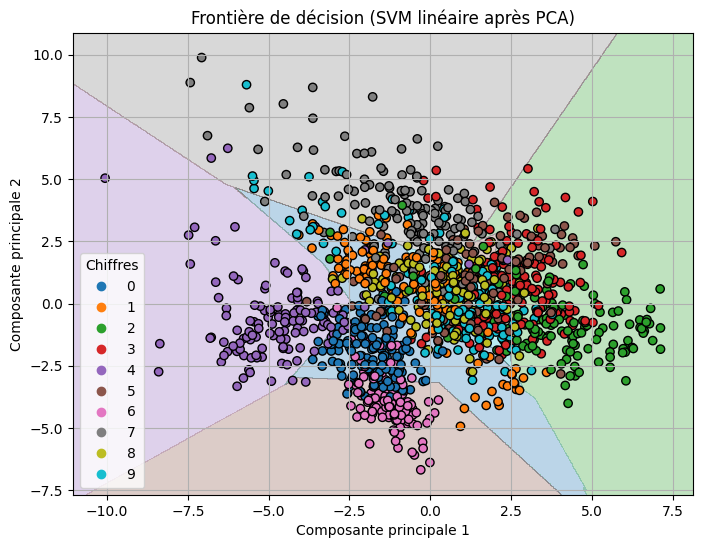

In [24]:
import numpy as np

# Création d'une grille
h = .02  # step
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Prédiction sur la grille
Z = clf_linear.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Affichage
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap=plt.cm.tab10, alpha=0.3)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Chiffres")
plt.title("Frontière de décision (SVM linéaire après PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()


TASK 3 — KMeans pour regrouper des clients en profils

Importation des bibliothèques

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

 chargement de dataset

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
df = pd.read_excel('/content/drive/MyDrive/Full pack IA/Module2:Machine Learning/Online Retail.xlsx')

In [28]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


Nettoyage des données

In [29]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [30]:
df = df.dropna(subset=['CustomerID'])

In [46]:
df.loc[:, 'Description'] = df['Description'].fillna(df['Description'].mode()[0])

 Création de la colonne TotalPrice

In [47]:
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [48]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


Création de la table RFM (Recency, Frequency, Monetary)

Recency (récence) : nombre de jours depuis la dernière commande

Frequency (fréquence) : nombre total de commandes

Monetary (montant) : montant total dépensé



In [49]:
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
import datetime
last_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()

Standardisation des données

In [50]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

Choisir le bon nombre de clusters

1. Méthode du coude (Elbow Method)

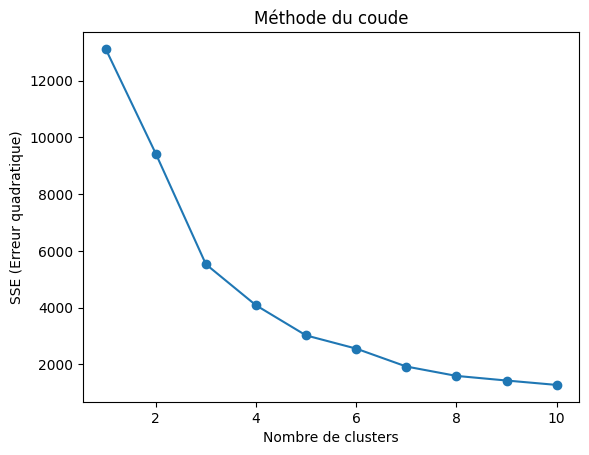

In [36]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE (Erreur quadratique)')
plt.title('Méthode du coude')
plt.show()

2. Score de silhouette

In [37]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f'k={k}, silhouette_score={score:.3f}')

k=2, silhouette_score=0.557
k=3, silhouette_score=0.588
k=4, silhouette_score=0.614
k=5, silhouette_score=0.590
k=6, silhouette_score=0.515
k=7, silhouette_score=0.521
k=8, silhouette_score=0.494
k=9, silhouette_score=0.469
k=10, silhouette_score=0.425


Appliquer KMeans avec k=4

In [38]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

Analyse des clusters

In [39]:
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Nombre de clients'})


,Recency,Frequency,Monetary,Nombre de clients
Cluster,,,,
0,10.752577,28.510309,12168.264691,194
1,248.927577,1.805942,455.110716,1077
2,5.090909,109.909091,124312.306364,11
3,42.780906,4.370550,1320.981506,3090


Réduction de dimensions avec PCA (pour visualiser les clusters)

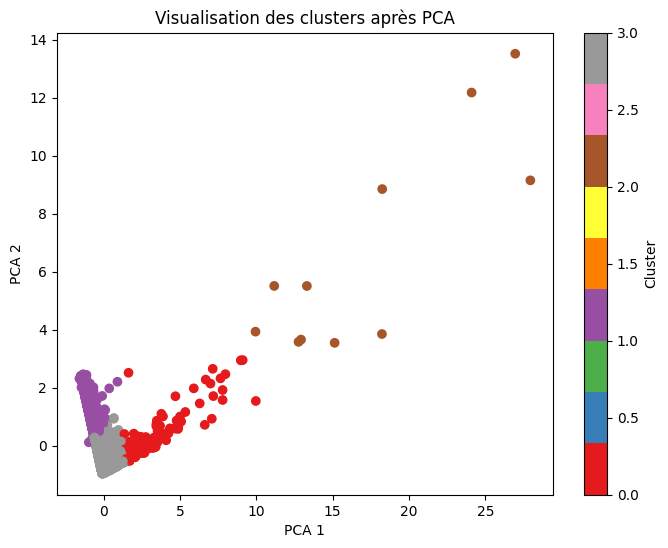

In [40]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=rfm['Cluster'], cmap='Set1')
plt.title('Visualisation des clusters après PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

Interprétation des résultats et proposision des actions marketing

Interprétation:
Cluster 0 (Inactifs) : Clients non récents, achètent rarement, dépensent peu. Groupe majoritaire désengagé.

Cluster 1 (Occasionnels) : Clients avec achats modérément récents, fréquence et dépenses moyennes.

Cluster 2 (Réguliers) : Clients récents, achètent souvent, dépenses moyennes à élevées. Engagés.

Cluster 3 (VIP) : Client très récent, achète fréquemment, dépense énormément. Très fidèle.

Actions marketing:
Cluster 0 : Relancer par e-mails promotionnels (ex. 20% de réduction), enquêter sur leur inactivité.

Cluster 1 : Encourager la fidélité avec des points de récompense, offres personnalisées.

Cluster 2 : Récompenser avec des accès exclusifs (ex. ventes anticipées), proposer un programme de parrainage.
Cluster 3 : Fidéliser avec des réductions exclusives, relation personnalisée, impliquer comme ambassadeur.
